# Text classification

In [2]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [3]:
from transformers import pipeline
model = pipeline('sentiment-analysis', return_all_scores=True)
s = ['This product was a scam']
print(model(s)[0][1])

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


/root/miniconda3/lib/python3.8/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.
You are using torch==1.11.0+cu113, but torch>=1.12.0 is required to use TapasModel. Please upgrade torch.


{'label': 'POSITIVE', 'score': 0.0003391572099644691}


Partition explainer: 2it [00:11, 11.04s/it]               


expected: 0.31
prediction: 0.00


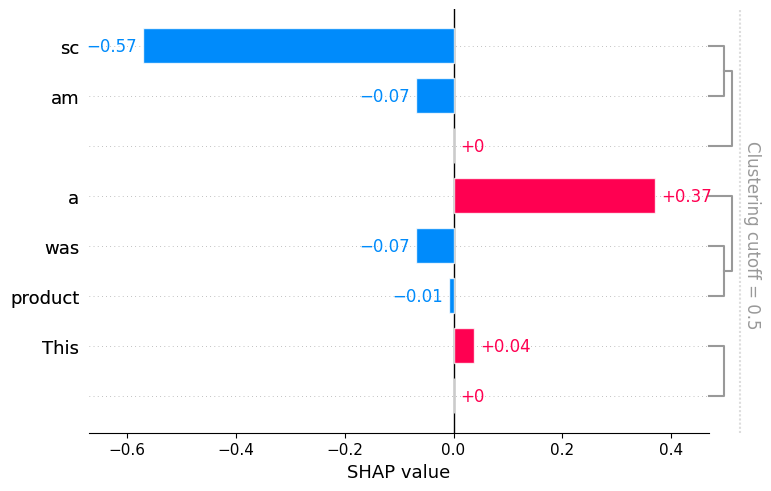

In [4]:
import shap
explainer = shap.Explainer(model)
shap_values = explainer(s)
print("expected: %.2f" % shap_values.base_values[0][1])
print("prediction: %.2f" % model(s)[0][1]['score'])
shap.plots.bar(shap_values[0, :, 'POSITIVE'])


# Experimenting with the masker

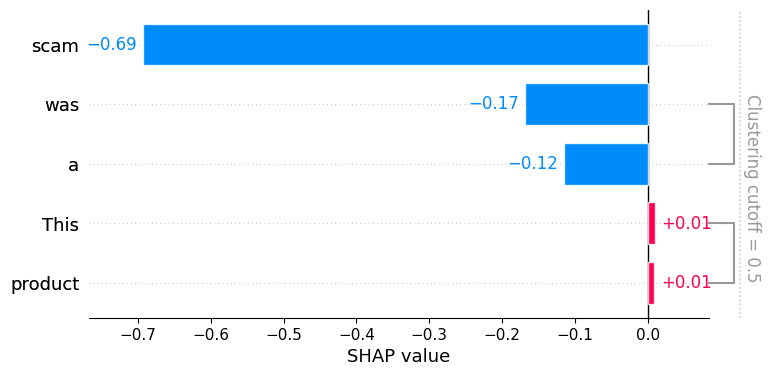

In [5]:
masker = shap.maskers.Text(tokenizer=r"\W+")
explainer = shap.Explainer(model, masker=masker)
shap_values = explainer(s)
shap.plots.bar(shap_values[0, :, 'POSITIVE'])


expected: 0.75
prediction: 1.00


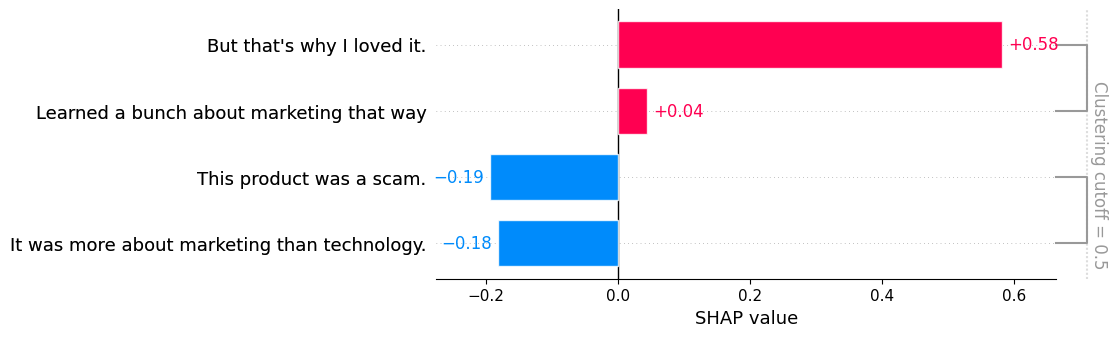

In [7]:
s2 = "This product was a scam." +\
    "It was more about marketing than technology." +\
    "But that's why I loved it." +\
    "Learned a bunch about marketing that way." 

masker = shap.maskers.Text(tokenizer=r"\.", mask_token=" ")
explainer = shap.Explainer(model, masker=masker)
shap_values = explainer([s2])
print("expected: %.2f" % shap_values.base_values[0][1])
print("prediction: %.2f" % model(s2)[0][1]['score'])
shap.plots.bar(shap_values[0, :, 'POSITIVE'])


expected: 1.00
prediction: 1.00


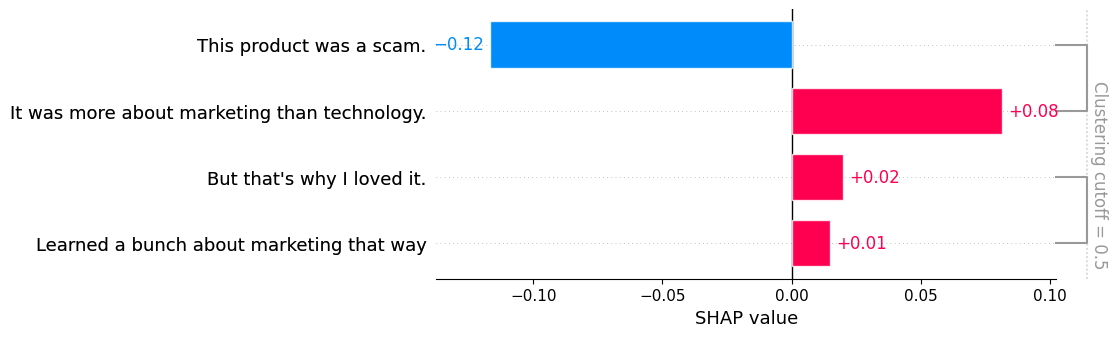

In [8]:
masker = shap.maskers.Text(tokenizer=r"\.", mask_token="I love it", collapse_mask_token=True)
explainer = shap.Explainer(model, masker=masker)
shap_values = explainer([s2])
print("expected: %.2f" % shap_values.base_values[0][1])
print("prediction: %.2f" % model(s2)[0][1]['score'])
shap.plots.bar(shap_values[0, :, 'POSITIVE'])

expected: 0.00
prediction: 1.00


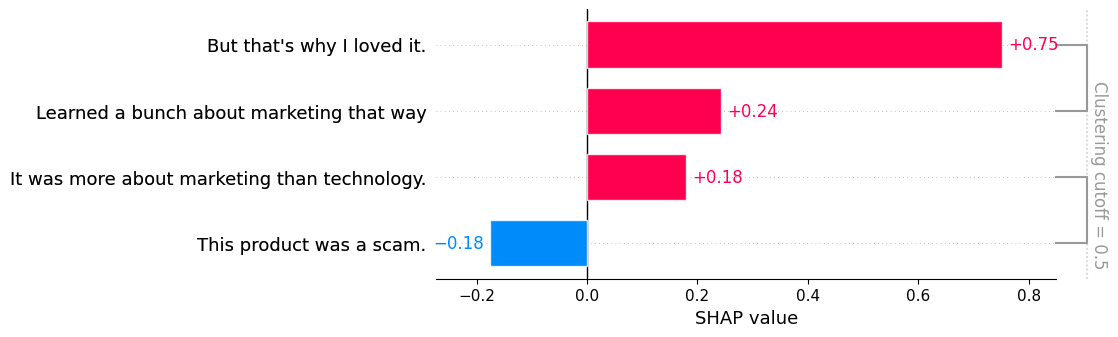

In [9]:
masker = shap.maskers.Text( tokenizer=r"\.", mask_token='I hate it', collapse_mask_token=True )
explainer = shap.Explainer(model, masker=masker)
shap_values = explainer([s2])
print("expected: %.2f" % shap_values.base_values[0][1])
print("prediction: %.2f" % model(s2)[0][1]['score'])
shap.plots.bar(shap_values[0, :, 'POSITIVE'])


expected: 0.96
prediction: 1.00


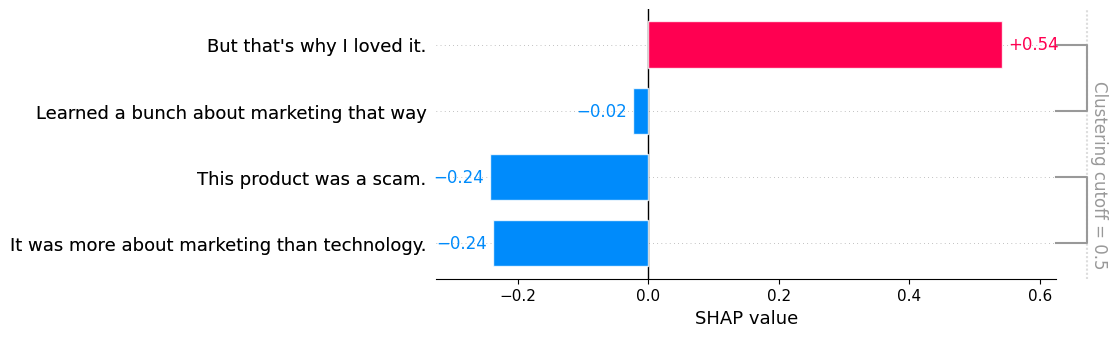

In [10]:
masker = shap.maskers.Text( tokenizer=r"\.", mask_token='...', collapse_mask_token=True )
explainer = shap.Explainer(model, masker=masker)
shap_values = explainer([s2])
print("expected: %.2f" % shap_values.base_values[0][1])
print("prediction: %.2f" % model(s2)[0][1]['score'])
shap.plots.bar(shap_values[0, :, 'POSITIVE'])


expected: 0.75
prediction: 1.00


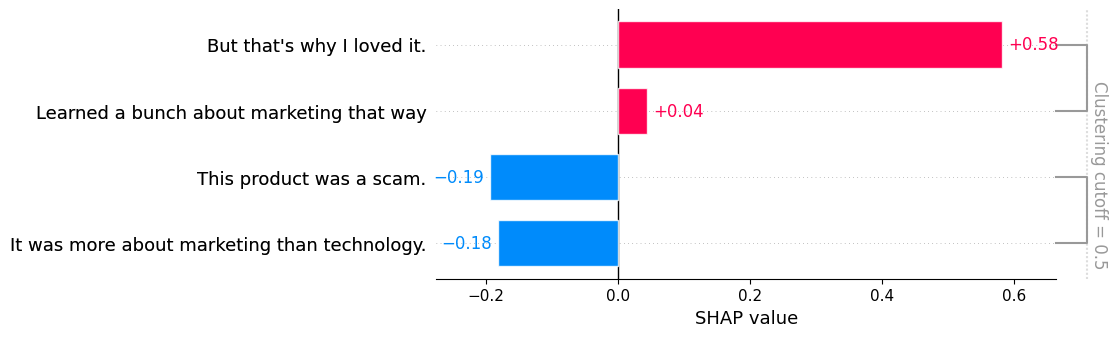

In [11]:
masker = shap.maskers.Text( tokenizer=r"\.", mask_token=' ', collapse_mask_token=True )
explainer = shap.Explainer(model, masker=masker)
shap_values = explainer([s2])
print("expected: %.2f" % shap_values.base_values[0][1])
print("prediction: %.2f" % model(s2)[0][1]['score'])
shap.plots.bar(shap_values[0, :, 'POSITIVE'])


# Using logits instead of probabilities

In [12]:
model2 = shap.models.TransformersPipeline( model, rescale_to_logits=True )
model2(s)

array([[ 7.9887276, -7.9887076]])

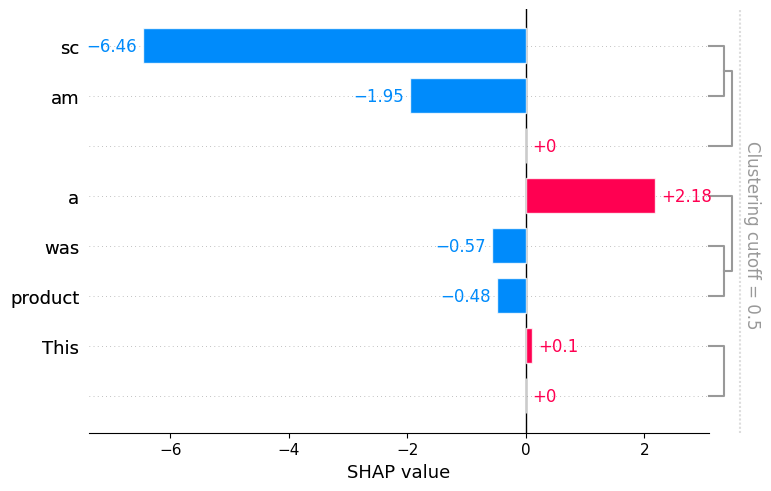

In [13]:
explainer2 = shap.Explainer(model2)
shap_values2 = explainer2(s)
shap.plots.bar(shap_values2[0,:, 'POSITIVE'])

# Explaining a text-to-text model

In [14]:
from transformers import AutoTokenizer, AutoModelForCausalLM
tokenizer = AutoTokenizer.from_pretrained('gpt2')
model = AutoModelForCausalLM.from_pretrained('gpt2')

In [15]:
import torch 
# Set seed for consistent results 
torch.manual_seed(0) 
input_text = 'He insulted Italian cuisine by' 
# Encode input text 
input_ids = tokenizer.encode(input_text, return_tensors='pt') 
# Sample instead of returning the most likely token 
model.config.do_sample=True 
# Set maximum length
model.config.max_new_tokens = 30 
# Generate text with stop_token set to "."
output = model.generate(input_ids) 
# Decode output text 
output_text = tokenizer.decode(output[0], skip_special_tokens=True)
print('The result: "' + output_text + '"')


You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The result: "He insulted Italian cuisine by throwing spaghetti at the tables and throwing rocks at the local biker's peloton, and he did something about it by showing that she needs a change"


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  0%|          | 0/20 [00:00<?, ?it/s]

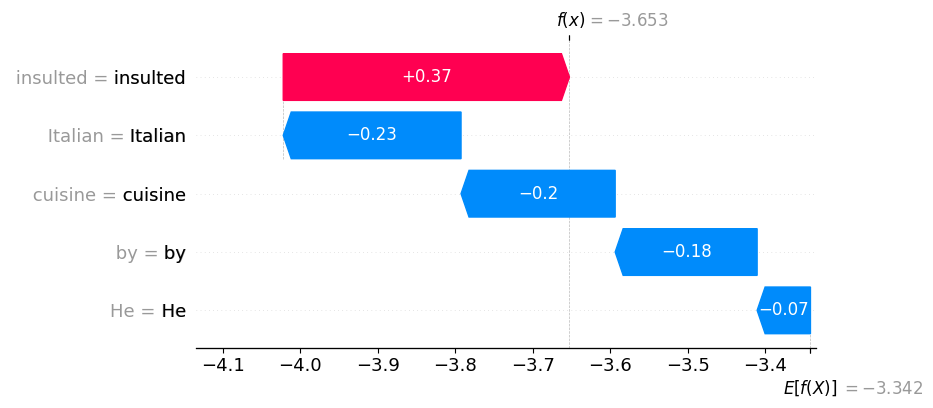

In [16]:
torch.manual_seed(0) 
# Setting the model to decoder to prevent input repetition. 
model.config.is_decoder = True 
explainer = shap.Explainer(model, tokenizer) 
shap_values = explainer([input_text]) 
shap.plots.waterfall(shap_values[0, :, 5 + 1])
